# Clustering Documents

In this notebook, you'll learn about the **Latent Dirichlet Allocation** (LDA) algorithm, and how to use it to cluster documents based on automatically generated topics, made out of their content words.

Key-learning:
- Unsupervised machine learning for NLP
- Clustering Documents
- LDA
- python packages: *pandas*, [*gensim*](https://pypi.org/project/gensim/)

Terms in this notebook:
- Bag of Words (BoW)
- LDA
- Clustering
- TF/IDF

This notebook includes two recommended videos (total length: 25min).

Estimated reading duration: 1-2h.


# Setup

We start by importing [pandas](https://pandas.pydata.org/) - an essential tool for data scientists!

We load a .CSV (Comma Seperated Values) file of German news articles from https://github.com/tblock/10kGNAD


In [1]:
from IPython.display import YouTubeVideo

In [2]:
import pandas as pd

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

Pandas is a useful package to load CSV files and to parse them. It can also parse TSV - separated by tabs, or as in our case, separated by a `;`.  
Pandas is often used as the first-step for data scientists to load and analyze data.

In [3]:
df_articles = pd.read_csv('https://raw.githubusercontent.com/tblock/10kGNAD/master/articles.csv',
                 sep=';',       # this file is actually a TSV, separated by ";"
                 on_bad_lines='skip',
                 header=None,       # There is no header line for this CSV...
                 # .. so we define the column names here:
                 names=['article_category', 'content'],
                 # And by specifiying the column as a Categorical type, we can save computer memory! Yay!
                 dtype={'article_category': 'category'})

**Note:** Specifying a column with repeated strings as a category is a good Pandas' trick to be aware of. Often the dataset can't fit into the memory, and by specifiying columns as a categorical column when loading the data (`pd.read_csv`), we get to spare memory and allow the dataset to fit the working memory better.

In [4]:
df_articles

,article_category,content
0,Etat,"Die ARD-Tochter Degeto hat sich verpflichtet, ..."
1,Etat,App sei nicht so angenommen worden wie geplant...
2,Etat,Mitarbeiter überreichten Eigentümervertretern ...
3,Etat,Service: Jobwechsel in der Kommunikationsbranc...
4,Etat,Was Sie über diese Woche wissen sollten - und ...
...,...,...
9571,Wissenschaft,Die Fundstelle in Südengland ist Unesco-Weltku...
9572,Wissenschaft,Im Team arbeitet auch ein Inspektor der sudane...
9573,Wissenschaft,Die zentrale Frage des Projekts: Siedelten Ägy...
9574,Wissenschaft,Klimatische Verschlechterungen dürften zur Auf...


Our corpus contains 9 categories, as seen below ('Etat', 'Inland', 'International', 'Kultur', 'Panorama', 'Sport', 'Web', 'Wirtschaft', 'Wissenschaft').
However, our plan now is to **ignore them**, and instead, use an **un**supervised algorithm to deduct the topics only by the articles content.   
Or in other words: we will *cluster* those documents based on their content.

In [5]:
df_articles['article_category'].cat.categories

Index(['Etat', 'Inland', 'International', 'Kultur', 'Panorama', 'Sport', 'Web',
       'Wirtschaft', 'Wissenschaft'],
      dtype='object')

# Clustering with Latent Dirichlet Allocation (LDA)

## Introduction

We start by clustering our data as an unsupervised learning task: **topic modeling**.

There are many different methods to cluster documents. One of these methods is *topic modeling* - where an algorithm assigns a *topic* to each document and clusters these documents by these topics.

Documents can be represented as a distribution of their words: their occurrences and frequencies. A set of words, which are relatively not frequent but are common to several documents, can express a document topic.  
For example, suppose we locate documents with the words 'Android', 'OnePlus' and 'iPhone' in them. Based on the frequency of these words, we could assume that these documents are related to mobile phones.

[Dirichlet](https://en.wikipedia.org/wiki/Dirichlet_distribution) is a distribution on probability distributions. In other words, it can handle the frequency of which a set of words appear (which have by themselves, each one, a frequency).

For a deeper mathematical explanation of this distribution, watch this recommended video: https://www.youtube.com/watch?v=nfBNOWv1pgE

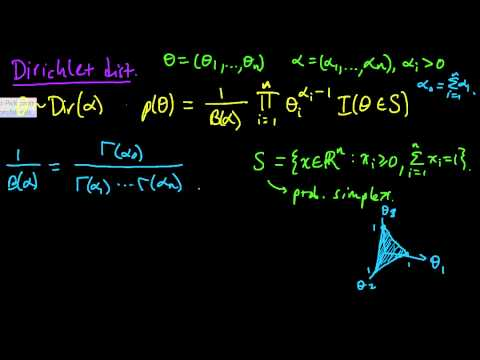

In [6]:
YouTubeVideo('nfBNOWv1pgE')

LDA is an unsupervised algorithm that assigns topics to every document. These topics are described as a set of words.  
Each document can contain several topics - more than just one topic.  
For example, some article about Apple can be 80% mobile phones and 20% about business innovations or income.

The [LDA paper](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) is a milestone in NLP and one of the recommended readings.

If you're interested to learn more about the algorithm method, watch this video: https://www.youtube.com/watch?v=DWJYZq_fQ2A.

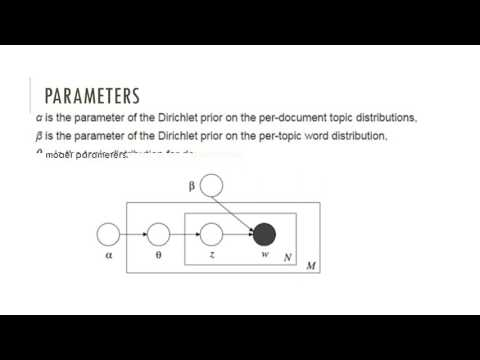

In [7]:
YouTubeVideo('DWJYZq_fQ2A')

Now, let's examine our German data set with LDA:

In previous exercises, you got to know NLTK.

### Stemming
Here we will also use NLTK's methods of **stemming** the words. By returning to the root of the word, its stem, we reduce the dimensionality: the number of words in the vocabulary decreases. For example, instead of having different words for the singular and plural form - 'word' <--> 'words' or 'Kanzler', 'Kanzlers', 'Kanzlei', etc., we trim those words into 'Kanzl'. Hence we can reduce the size of the vocabulary by at least half.

### Stop Words
We will also remove `stopwords` from our text. In English, words such as: `a`, `an`, and `the` will be removed, as they don't add much to the meaning of the sentence. For each language, there is a different curated list of such words, and NLTK is a great source for those.

### GenSim
In this exercise, you'll be introduced to another package, specialized in topic modeling, called `gensim`:
https://radimrehurek.com/gensim/



In [8]:
%pip install -U gensim --quiet

In [9]:
from pprint import pprint       # for printing objects nicely

from gensim import corpora, models
from gensim.utils import simple_preprocess      # revised: simple_preprocess already removes short words (shorter than 2 chars), lowercases it and removes accents --> so below preprocessing unnecessary?!

# Instead of the gensim English stopwords from gensim.parsing.preprocessing import STOPWORDS we use nltk's German stopwords:
from nltk.corpus import stopwords

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

import numpy as np

from random import choice

np.random.seed(1234)

"""
The hyperparameters won't necessarily remove the stop-words, unless their appear
is above the stated frequency. The best way to ensure their removal is to preprocess
the text before passing it to the LDA model (either for inference or during training),
and remove them manually.
"""

"\nThe hyperparameters won't necessarily remove the stop-words, unless their appear \nis above the stated frequency. The best way to ensure their removal is to preprocess \nthe text before passing it to the LDA model (either for inference or during training), \nand remove them manually.\n"

In [10]:
# Initialize the Stemmers
stemmer = SnowballStemmer('german')
german_stop_words = set(stopwords.words('german'))


def lemmatize_stemming(text):
  """lemmatize and stem a word"""
  return stemmer.stem(text)


def preprocess(text):
  """lemmatize and remove stopwords"""
  result = [lemmatize_stemming(token)
            for token in simple_preprocess(text)
            if token not in german_stop_words and len(token) > 3]
  return result

In our DataFrame, we have a table that contains the articles and their topics.

We only need the articles for this tasks - we will create our own topics. So, let's start by converting the articles column into a ist of all the articles:

In [11]:
all_articles = df_articles['content'].to_list()
all_articles[:5]

['Die ARD-Tochter Degeto hat sich verpflichtet, ab August einer Quotenregelung zu folgen, die für die Gleichstellung von Regisseurinnen sorgen soll. In mindestens 20 Prozent der Filme, die die ARD-Tochter Degeto produziert oder mitfinanziert, sollen ab Mitte August Frauen Regie führen. Degeto-Chefin Christine Strobl folgt mit dieser Selbstverpflichtung der Forderung von Pro Quote Regie. Die Vereinigung von Regisseurinnen hatte im vergangenen Jahr eine Quotenregelung gefordert, um den weiblichen Filmschaffenden mehr Gehör und ökonomische Gleichstellung zu verschaffen. Pro Quote Regie kritisiert, dass, während rund 50 Prozent der Regie-Studierenden weiblich seien, der Anteil der Regisseurinnen bei Fernsehfilmen nur bei 13 bis 15 Prozent liege. In Österreich sieht die Situation ähnlich aus, auch hier wird von unterschiedlichen Seiten Handlungsbedarf angemahnt. Aber wie soll dieser aussehen? Ist die Einführung der Quotenregelung auch für die österreichische Film- und Fernsehlandschaft sinn

## Preprocessing

Let's see an example, what happens when we pre-process a document.

Look at the output of this cell, and compare the tokenized original document, to the lemmatized document:

In [12]:
print('original document: ')
article = choice(all_articles)
print(article, "\n")

# This time, we don't care about punctuations as tokens (Can you think why?):
print('original document, broken into words: ')
words = [word for word in article.split(' ')]
print(words, "\n")
print('Vocabulary size of the original article:', len(set(words)))

# Now let's see what happens when we pass the article into our preprocessing
# method (i.e. additionally removing stopwords):
print('\n\n tokenized and lemmatized document: ')
preprocessed_article = preprocess(article)
print(preprocessed_article, '\n')
print('Vocabulary size after preprocessing:', len(set(preprocessed_article)))

original document: 
Heute-Chefin will sich am einen oder anderen interessanten Start-up beteiligen – New Yorker Boulevard-Kampagnen würden "salonlinken Gutmenschen" in Österreich "Herzinfarkt" bescheren. Wien/New York – Bei den Medien sind die USA nach wie vor Avantgarde, der Elitegedanke ist nachahmenswert, doch die Infrastruktur des täglichen Lebens ist oft rückständig. Das ist die erste Zwischenbilanz der Verlegerin und Heute-Herausgeberin Eva Dichand nach vier Monaten Studienzeit zwischen New York und Silicon Valley. Unsere bisherige Erfahrung ist jedenfalls, dass man enorm viel lernen kann. Hier tut sich so viel, dass einem der Kopf saust, schreibt Dichand, die seit September mit ihren Kindern und ihrem Mann und Kronen Zeitung-Herausgeber Christoph Dichand in New York lebt, in einem Essay für die aktuelle Ausgabe des neu konzipierten Wirtschaftsmagazins trend. Die Dichands besuchten bisher traditionelle Verlagshäuser wie New York Times, Washington Post oder Los Angeles Times sowie

Now let's pre-process all the documents.  
This is a heavy procedure, and may take a bit ;)

In [13]:
processed_docs = list(map(preprocess, all_articles))
processed_docs[:10]

[['tocht',
  'degeto',
  'verpflichtet',
  'august',
  'quotenregel',
  'folg',
  'gleichstell',
  'regisseurinn',
  'sorg',
  'mindest',
  'prozent',
  'film',
  'tocht',
  'degeto',
  'produziert',
  'mitfinanziert',
  'soll',
  'mitt',
  'august',
  'frau',
  'regi',
  'fuhr',
  'degeto',
  'chefin',
  'christin',
  'strobl',
  'folgt',
  'forder',
  'quot',
  'regi',
  'verein',
  'regisseurinn',
  'vergang',
  'jahr',
  'quotenregel',
  'gefordert',
  'weiblich',
  'filmschaff',
  'mehr',
  'gehor',
  'okonom',
  'gleichstell',
  'verschaff',
  'quot',
  'regi',
  'kritisiert',
  'rund',
  'prozent',
  'regi',
  'studier',
  'weiblich',
  'seien',
  'anteil',
  'regisseurinn',
  'fernsehfilm',
  'prozent',
  'lieg',
  'osterreich',
  'sieht',
  'situation',
  'ahnlich',
  'seit',
  'handlungsbedarf',
  'angemahnt',
  'ausseh',
  'einfuhr',
  'quotenregel',
  'osterreich',
  'film',
  'sinnvoll',
  'diskuti',
  'forum'],
 ['angenomm',
  'word',
  'geplant',
  'weg',
  'gering',
  '

## Setting Up The Dictionary

Our preprocessing is complete.

We now need to calculate the occurance frequencies of each of our stemmed words. But first, we will create a vocabulary dictionary where every word appears once. Every article would be represented as a [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model), an unordered set of words that the article contain.

---

**Q:** Why is it called bag-of-words?

**A:** The term "bag-of-words" comes from the idea that we represent text as an unordered collection (or "bag") of words.

- Words are treated as isolated items.
- The model does not preserve syntax or grammar.
- Only word counts matter.

E.g.: "The cat sleeps on the mat."

Bag-of-words representation: {"the": 2, "cat": 1, "sleeps": 1, "on": 1, "mat": 1}.

In [14]:
dictionary = corpora.Dictionary(processed_docs)

Let's take a look:

In [15]:
for idx, (k, v) in enumerate(dictionary.iteritems()):
    print(k, v)
    if idx >= 10:
        break


# NB: 'enumerate' is a great python function!
# It automatically creates an index, an auto-incremented counter variable,
# that represents the position of every object in the collection.

# Read more about it here: https://realpython.com/python-enumerate/

0 ahnlich
1 angemahnt
2 anteil
3 august
4 ausseh
5 chefin
6 christin
7 degeto
8 diskuti
9 einfuhr
10 fernsehfilm


Secondly, we filter the tokens that may appear to often.

We have full control over the process.

### Model Hyperparameter tuning

### Your Turn:
#### Exercise 1 - Hyperparameter effect on the model output:
**Q:** How would changing these parameters influence the result?  
After running this example, please return here to change them and try them out.

**A:**

- filter_tokens_if_container_documents_are_less_than:

    This parameter removes words that appear in fewer than x (initially: 15) documents across the corpus.

- filter_tokens_if_appeared_percentage_more_than:

    This parameter removes words that appear in more than x (initially 50%) of the documents.

- keep_the_first_n_tokens:

    Limits the dictionary size to the first x (initially 100,000) most frequent tokens.

- num_of_topics:

    Determines the number of topics the LDA model will discover.

In [16]:
# Model hyper parameters:

# These are the dictionary preparation parameters:
filter_tokens_if_container_documents_are_less_than = 20
filter_tokens_if_appeared_percentage_more_than = 0.2
keep_the_first_n_tokens = 20000

# LDA Parameters:
num_of_topics = 20

# NB: Also remove additional stoopwords such as "viel", "dabei", "zeitgleich"?

In [17]:
dictionary.filter_extremes(
    no_below=filter_tokens_if_container_documents_are_less_than,
    no_above=filter_tokens_if_appeared_percentage_more_than,
    keep_n=keep_the_first_n_tokens)

We now create a [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) (BOW) dictionary for each document, using [gensim's dictionary](https://radimrehurek.com/gensim/corpora/dictionary.html) tool.

It will be in the format of:

```{ 'word_id': count }```


In [18]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

Let's take a look at the result.

Our corpus contains now only word_ids, not the words themselves, so we have to peek into the dictionary to know which word that id represents:

In [19]:
# Randomly choose an article from the corpus:
sample_bow_doc = choice(bow_corpus)

print('The processed bag-of-word document is just pairs of (word_id, # of occurnces) and looks like this:')
print(sample_bow_doc, '\n\n')

print ('We peek in the dictionary: for each word_id, we get its assigned word:')
for word_id, word_freq in sample_bow_doc:
    real_word = dictionary[word_id]
    print(f'Word #{word_id} ("{real_word}") appears {word_freq} time.')

The processed bag-of-word document is just pairs of (word_id, # of occurnces) and looks like this:
[(321, 1), (386, 1), (391, 1), (512, 1), (680, 1), (1240, 1), (1846, 1), (2346, 1), (2438, 1), (4190, 1), (5016, 1)] 


We peek in the dictionary: for each word_id, we get its assigned word:
Word #321 ("steht") appears 1 time.
Word #386 ("artikel") appears 1 time.
Word #391 ("basier") appears 1 time.
Word #512 ("grund") appears 1 time.
Word #680 ("rechtlich") appears 1 time.
Word #1240 ("verfug") appears 1 time.
Word #1846 ("einig") appears 1 time.
Word #2346 ("dutzend") appears 1 time.
Word #2438 ("tot") appears 1 time.
Word #4190 ("genf") appears 1 time.
Word #5016 ("volltext") appears 1 time.


## LDA model using Bag-of-words

Let's start by applying the LDA model using the bag-of-words (warning: this could take a while):

In [20]:
lda_model = models.LdaMulticore(bow_corpus,
                                num_topics=num_of_topics,
                                id2word=dictionary,
                                passes=5,
                                workers=2)

It is done!

Now we can observe which topics the model had extracted from the documents.

- *Topics* are made of sets of words and their distribution for that topic, representing their weight in that topic.
- Every document may be composed of multiple topics, with different weights representing the relation to each topics.

We will loop over the extracted topics and examine the words that construct them.

In [21]:
for idx, topic in lda_model.print_topics(num_of_topics):
    print(f'Topic: {idx} \t Words: {topic}')

Topic: 0 	 Words: 0.009*"weg" + 0.006*"gericht" + 0.005*"fall" + 0.005*"prasident" + 0.004*"deutsch" + 0.004*"ermittl" + 0.004*"jahrig" + 0.004*"urteil" + 0.004*"erklart" + 0.004*"behord"
Topic: 1 	 Words: 0.011*"million" + 0.009*"prozent" + 0.008*"milliard" + 0.007*"chef" + 0.006*"partei" + 0.006*"wahl" + 0.005*"volkswag" + 0.004*"unternehm" + 0.004*"regier" + 0.004*"parlament"
Topic: 2 	 Words: 0.015*"spiel" + 0.007*"minut" + 0.007*"salzburg" + 0.007*"sieg" + 0.006*"train" + 0.006*"punkt" + 0.005*"rapid" + 0.005*"team" + 0.005*"zweit" + 0.005*"saison"
Topic: 3 	 Words: 0.005*"polit" + 0.005*"standard" + 0.005*"grun" + 0.004*"ganz" + 0.003*"partei" + 0.003*"frag" + 0.003*"wahl" + 0.003*"geht" + 0.003*"zeit" + 0.003*"war"
Topic: 4 	 Words: 0.013*"appl" + 0.012*"nutz" + 0.008*"gerat" + 0.008*"windows" + 0.007*"microsoft" + 0.007*"smartphon" + 0.005*"version" + 0.004*"eig" + 0.004*"iphon" + 0.004*"android"
Topic: 5 	 Words: 0.011*"fluchtling" + 0.008*"europa" + 0.008*"turkei" + 0.008*"re

## TF / IDF

Let's take it one step further. We will cluster our document by running the LDA using [TF/IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).

We start with TF/IDF calculation on our bag-of-words.
TF/IDF accepts a dictionary of word frequencies as an input, and it calculates the term frequency and the inversed document frequency accordingly.

Its output is a re-weighted dictionary of the documents term frequencies:

In [22]:
# Initialize a tfidf from our corpus:
tfidf = models.TfidfModel(bow_corpus)

# Apply it on our corpus:
tfidf_corpus = tfidf[bow_corpus]

pprint(tfidf_corpus[0][:10])

# NB: output: [(word_id, tfidf_weight)]

[(0, 0.07673693928524966),
 (1, 0.09828379858287715),
 (2, 0.17921434585291837),
 (3, 0.12635614240398332),
 (4, 0.1219329048785731),
 (5, 0.15013721194664972),
 (6, 0.12025824665111713),
 (7, 0.10885416496515171),
 (8, 0.19346033050601905),
 (9, 0.06296639745581849)]


In [23]:
# The new tfidf corpus is just our corpus - but transformed. It has the same size of documents:
assert len(bow_corpus) == len(tfidf_corpus)

Now let's apply LDA on the tfidf corpus, with the same amount of topics.

You can play with the # of passes, if the model doesn't converge properly.

In [24]:
lda_model_tfidf = models.LdaMulticore(tfidf_corpus,
                                      num_topics=num_of_topics,
                                      id2word=dictionary,
                                      passes=15,
                                      workers=4)

In [25]:
for idx, topic in lda_model_tfidf.print_topics(num_of_topics):
    print(f'Topic: {idx} \t Word: {topic}')

Topic: 0 	 Word: 0.005*"princ" + 0.005*"philosoph" + 0.005*"betriebsrat" + 0.004*"auszeichn" + 0.004*"zertifikat" + 0.004*"cambridg" + 0.004*"dissertation" + 0.003*"tier" + 0.003*"vogel" + 0.003*"forsch"
Topic: 1 	 Word: 0.008*"chinas" + 0.008*"peking" + 0.006*"china" + 0.006*"prozent" + 0.005*"chines" + 0.005*"moskau" + 0.005*"agypt" + 0.004*"russisch" + 0.004*"kairo" + 0.004*"milliard"
Topic: 2 	 Word: 0.008*"lufthansa" + 0.008*"prozent" + 0.007*"tesla" + 0.006*"volkswag" + 0.005*"diesel" + 0.005*"motor" + 0.005*"lit" + 0.005*"fahrzeug" + 0.004*"autos" + 0.004*"airbus"
Topic: 3 	 Word: 0.006*"archaolog" + 0.006*"grab" + 0.005*"antik" + 0.004*"spot" + 0.004*"franco" + 0.004*"lehrling" + 0.003*"scott" + 0.003*"pilot" + 0.003*"frisch" + 0.003*"cyb"
Topic: 4 	 Word: 0.004*"toronto" + 0.004*"gastronomi" + 0.004*"minnesota" + 0.004*"henry" + 0.003*"schiedsgericht" + 0.003*"felix" + 0.003*"boston" + 0.003*"cent" + 0.003*"amazon" + 0.003*"sanaa"
Topic: 5 	 Word: 0.039*"volltext" + 0.037*"bas

## Inference

Now that we have a topic-modeler, let's use it on one of the articles.

In [26]:
# Randomly pick an article:
test_doc = choice(range(len(processed_docs)))
processed_docs[test_doc][:50]

['zweisatzsieg',
 'serb',
 'lajovic',
 'bringt',
 'duell',
 'topgesetzt',
 'spani',
 'buenos',
 'air',
 'dominic',
 'thiem',
 'steht',
 'dollar',
 'turni',
 'buenos',
 'air',
 'halbfinal',
 'numm',
 'funf',
 'gesetzt',
 'gewann',
 'freitag',
 'doppelpartn',
 'dusan',
 'lajovic',
 'serbi',
 'trifft',
 'topgesetzt',
 'spani',
 'rafael',
 'nadal',
 'thiem',
 'serb',
 'buenos',
 'air',
 'doppel',
 'viertelfinal',
 'vorgestoss',
 'beginn',
 'kaum',
 'problem',
 'beim',
 'stand',
 'nahm',
 'numm',
 'ranking',
 'erstmal',
 'servic',
 'eig',
 'aufschlag']

Using the original BOW model:

In [27]:
for index, score in sorted(lda_model[bow_corpus[test_doc]], key=lambda tup: -1*tup[1]):
    print(f"Topic match score: {score} \nTopic: {lda_model.print_topic(index, num_of_topics)}")

Topic match score: 0.9935351014137268 
Topic: 0.006*"thiem" + 0.006*"jahrig" + 0.005*"million" + 0.005*"start" + 0.005*"zweit" + 0.005*"sieg" + 0.005*"renn" + 0.004*"spiel" + 0.004*"numm" + 0.004*"satz" + 0.004*"turni" + 0.003*"best" + 0.003*"dritt" + 0.003*"stund" + 0.003*"schweiz" + 0.003*"sech" + 0.003*"platz" + 0.003*"weltcup" + 0.003*"vier" + 0.003*"sonntag"


And with the TF/IDF model:

In [28]:
for index, score in sorted(lda_model_tfidf[bow_corpus[test_doc]], key=lambda tup: -1*tup[1]):
    print("Topic match score: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, num_of_topics)))

Topic match score: 0.6376955509185791	 
Topic: 0.008*"spiel" + 0.006*"sieg" + 0.006*"train" + 0.005*"saison" + 0.005*"minut" + 0.005*"fussball" + 0.005*"leagu" + 0.005*"rapid" + 0.005*"punkt" + 0.004*"tor" + 0.004*"salzburg" + 0.004*"mannschaft" + 0.004*"team" + 0.004*"jahrig" + 0.003*"sturm" + 0.003*"zweit" + 0.003*"bay" + 0.003*"platz" + 0.003*"liga" + 0.003*"bull"
Topic match score: 0.34386447072029114	 
Topic: 0.002*"prozent" + 0.002*"standard" + 0.002*"fluchtling" + 0.001*"europa" + 0.001*"million" + 0.001*"arbeit" + 0.001*"polit" + 0.001*"seien" + 0.001*"deutsch" + 0.001*"ganz" + 0.001*"hoh" + 0.001*"moglich" + 0.001*"dafur" + 0.001*"zeit" + 0.001*"hatt" + 0.001*"fall" + 0.001*"geht" + 0.001*"teil" + 0.001*"frag" + 0.001*"klein"


Calculating the [perplexity score](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94) (lower is better):

In [29]:
print('Perplexity: ', lda_model.log_perplexity(bow_corpus))
print('Perplexity TFIDF: ', lda_model_tfidf.log_perplexity(bow_corpus))

Perplexity:  -8.044787467035341
Perplexity TFIDF:  -8.438975585088516


### Exercise - inference

Now please try it on a new document!

Go to a news website, such as [orf.at](https://orf.at/) and copy an article of your choice here:

In [30]:
unseen_document = """Disney-Prinzessinnen leben gefährlich
Schneewittchen, Aschenputtel und Co. leben, wenn man den Geschichten glaubt, glücklich bis an ihr Lebensende. In Wahrheit sind die oft beneideten Disney-Heldinnen aber mit einer ganzen Reihe an Gesundheitsrisiken konfrontiert. Zu diesem Schluss kommt eine Studie in der traditionell nicht ganz ernst gemeinten Weihnachtsausgabe des „British Medical Journal“.
Wie jedes Jahr macht das renommierte Wissenschaftsmagazin in seiner Weihnachtausgabe Platz für humorvolle Forschungsarbeiten. Eine der nicht ganz ernst gemeinten Studien widmet sich dem gefährlichen Leben von Märchenprinzessinnen, deren Popularität durch Disney-Verfilmungen noch einmal deutlich gewachsen sei.
Wie das Team um Sanne van Dijk von der niederländischen Universität Twente schreibt, wurden die beliebten Filme bereits in früheren Untersuchungen kritisch hinterfragt: Sie fördern Stereotype, propagieren unnatürliche Schönheitsbilder sowie unrealistische Vorstellungen von Beziehungen, zeigte sich dort unter anderem.
Langfristige Gesundheitsrisiken
Bei all der Sorge um die meist minderjährigen Zuseher und Zuseherinnen habe man ganz auf das Wohl der Heldinnen selbst vergessen. Genau dieses stellten die Forscher und Forscherinnen nun in den Fokus der soeben erschienenen Studie. Angeblich leben die Prinzessinnen zwar glücklich bis ans Ende, aber wenn man genauer hinsieht, werde schnell klar, dass ihre jeweiligen Lebensumstände nicht besonders gesund sind, wie die Studie anhand mehrerer Beispiele illustriert.
So verbringe etwa das von allen für seine Schönheit bewunderte Schneewittchen viele Jahre unter der Knechtschaft seiner neidischen Stiefmutter. Aufgrund der fehlenden Sozialkontakte habe es ein erhöhtes Risiko für Herz-Kreislauf-Erkrankungen, Depressionen und Angststörungen. Zum Glück treffe sie dann auf die sieben Zwerge, die sie vor den Gefahren der Einsamkeit beschützen. Dann beiße sie allerdings in den vergifteten Apfel, was laut Dijk und Co. klarmacht, dass nicht einmal Äpfel immer gesund sind.
Handfeste Gefahren
Manche Prinzessinnen sehen sich laut der Studie mit noch handfesteren Problemen konfrontiert, etwa Aschenputtel, das in Staub und Dreck arbeitet und sogar darin schlafen muss. Das erhöhe das Risiko für chronische Lungenprobleme bis hin zu COPD (chronisch obstruktive Lungenkrankheit). Der Zauberglitter der guten Fee – vermutlich mit Aluminium überzogenes Mikroplastik – verschlimmere die Lage zusätzlich.
Konkret gefährlich lebe auch Pocahontas. Ihr neun Sekunden dauernder Sprung von den Klippen sei lebensgefährlich, der Felsen müsse geschätzt mehr als 250 Meter hoch sein. Schon aus deutlich geringeren Höhen seien Knochenbrüche wahrscheinlich. Und Dornröschens langer Schlaf erhöhe ihr Risiko für Schlaganfälle, Übergewicht und Diabetes. Zudem drohen bei langer Bettruhe Muskelschwund und Druckgeschwüre. Zum Glück küsse sie am Ende ein Prinz wach – allerdings ohne nach ihrer Zustimmung zu diesem Kuss zu fragen.
Ebenfalls gefährdet sind laut den Forschenden Jasmin („Aladdin“), Mulan, Belle („Die Schöne und das Biest“) und Rapunzel. Damit alle Prinzessinnen wirklich gesund bis an ihr Ende leben können, brauchte es jedenfalls dringend präventive Maßnahmen, so das Fazit der Forscherinnen und Forscher. Um ihr Wohlergehen sicherzustellen, sollten die Produzenten an Achtsamkeitstraining und Psychotherapie denken. Es wäre auch wichtig, das Zusammenleben mit Tieren zu trainieren sowie Schutzvorkehrungen gegen infektiöse und toxische Partikel einzuführen.
"""

bow_vector = dictionary.doc2bow(preprocess(unseen_document))

print("Simply printing the lda_model output would look like this:")
pprint(lda_model[bow_vector])

print("\nSo let's make it nicer, by printing the topic contents:")
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Simply printing the lda_model output would look like this:
[(3, 0.33407274), (9, 0.29905143), (19, 0.36171964)]

So let's make it nicer, by printing the topic contents:
Score: 0.3617202937602997	 Topic: 0.016*"forsch" + 0.009*"tier" + 0.008*"wissenschaft" + 0.006*"universitat" + 0.006*"studi"
Score: 0.3340752422809601	 Topic: 0.005*"polit" + 0.005*"standard" + 0.005*"grun" + 0.004*"ganz" + 0.003*"partei"
Score: 0.29904821515083313	 Topic: 0.020*"standard" + 0.010*"prozent" + 0.007*"hoh" + 0.006*"europa" + 0.005*"geld"


## Visualization

Finally, there are packages that can visulaize the results, such as [pyLDAvis](https://pypi.org/project/pyLDAvis/) and [tmplot](https://pypi.org/project/tmplot/).

Let's take a look at pyLDAvis visualization result.

**Please note:** this is an old and unmaintained package. It is easier to run it in Google-Colab than on your laptop. But, if you still try running it locally, please try **lowering your python version** (3.6 / 3.6 / 3.8) when you create the poetry environment for this exercise.

In [31]:
%pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 29.5 MB/s eta 0:00:00


In [32]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

bow_lda_data = gensimvis.prepare(lda_model, bow_corpus, dictionary)

pyLDAvis.display(bow_lda_data)

# Your turn - Do it yourself:

Replace the given corpus with one in another language - maybe your own native language? You can find corpora online, for example:
- https://www.corpusdata.org/intro.asp
- or here: https://www.clarin.eu/resource-families/newspaper-corpora
- or even in nltk: https://www.nltk.org/nltk_data/
- In this github, there are many datasets that can be loaded through their `raw` url: https://github.com/selva86/datasets

Careful: You will need to change the [Stemming](https://snowballstem.org/algorithms/) and the [Stopwords](https://www.kaggle.com/rtatman/stopword-lists-for-19-languages) to support your language. Make a web-search after the appropriate ones (if they exist..)

Use the notebook to reproduce the result.  
Try changing the parameters to get a *satisfying level of clustering*.  
Which parameters worked best for the language you chose?

In [33]:
from nltk.corpus import gutenberg
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

import time

nltk.download('gutenberg')

# Initialize English stemmer and stopwords
stemmer_en = SnowballStemmer('english')
english_stop_words = set(stopwords.words('english'))


def lemmatize_stemming(text):
    """Lemmatize and stem a word"""
    return stemmer_en.stem(text)


def preprocess(text):
    """Lemmatize and remove stopwords"""
    result = [lemmatize_stemming(token)
              for token in simple_preprocess(text)      # NB: from gensim.utils import simple_preprocess
              if token not in english_stop_words and len(token) > 3]
    return result


# Parameters
filter_tokens_if_container_documents_are_less_than = 2
filter_tokens_if_appeared_percentage_more_than = 0.5
keep_the_first_n_tokens = 10000
num_of_topics = 10
passes = 15

# Load Gutenberg texts
documents = [gutenberg.raw(file_id) for file_id in gutenberg.fileids()]
print(f"Loaded {len(documents)} documents.")

# Preprocess documents
tokenized_texts = [preprocess(doc) for doc in documents]

# Remove empty documents
tokenized_texts = [text for text in tokenized_texts if len(text) > 0]
print(f"Number of non-empty documents: {len(tokenized_texts)}")

# Create dictionary and filter
dictionary = Dictionary(tokenized_texts)
dictionary.filter_extremes(
    no_below=filter_tokens_if_container_documents_are_less_than,
    no_above=filter_tokens_if_appeared_percentage_more_than,
    keep_n=keep_the_first_n_tokens
)
print(f"Number of unique tokens after filtering: {len(dictionary)}")

# Create Bag-of-Words corpus
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# Debugging: Check corpus
if len(dictionary) == 0 or all(len(doc) == 0 for doc in corpus):
    print("Error: Corpus or dictionary is empty after preprocessing and filtering!")
    exit()

# Train LDA model
print("\nTraining LDA Model...")
start_time = time.time()
lda_model = LdaModel(
    corpus=corpus,
    num_topics=num_of_topics,
    id2word=dictionary,
    passes=passes
)
end_time = time.time()
print(f"LDA Model trained in {end_time - start_time:.2f} seconds")

# Print topics
for idx, topic in enumerate(lda_model.show_topics(num_topics=num_of_topics, num_words=10, formatted=False)):
    print(f"\nTopic {idx}:")
    print(", ".join([word for word, _ in topic[1]]))

# Visualize topics
vis = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


Loaded 18 documents.
Number of non-empty documents: 18
Number of unique tokens after filtering: 9175

Training LDA Model...
LDA Model trained in 5.54 seconds

Topic 0:
mariann, ann, edward, willoughbi, colonel, luci, charl, russel, walter, middleton

Topic 1:
hath, adam, satan, spake, paradis, bliss, thine, thyself, almighti, shalt

Topic 2:
unto, hath, shalt, israel, jerusalem, thine, saith, mose, jesus, thereof

Topic 3:
weep, infant, worm, virgin, vale, tiger, doth, merrili, moan, dost

Topic 4:
unto, israel, hath, shalt, saith, david, jesus, thine, thereof, mose

Topic 5:
whale, boat, ahab, harpoon, sperm, deck, chapter, mast, voyag, sailor

Topic 6:
buster, professor, gregori, polic, bull, farmer, anarchist, presid, colonel, secretari

Topic 7:
unto, whale, israel, hath, ahab, shalt, saith, boat, thine, jesus

Topic 8:
alic, susan, archer, francisco, guinea, arthur, louisa, talbot, attorney, frederick

Topic 9:
emma, weston, jane, churchil, bate, martin, smith, jackal, perri, surp

In [34]:
"""
from nltk.corpus import gutenberg, stopwords
from nltk.stem import WordNetLemmatizer
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, CoherenceModel, TfidfModel
from gensim.utils import simple_preprocess
from collections import Counter
import matplotlib.pyplot as plt
from pyLDAvis import gensim_models as gensimvis
import pyLDAvis
import nltk
import time

nltk.download('gutenberg')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize components
lemmatizer = WordNetLemmatizer()
english_stop_words = set(stopwords.words('english'))
custom_stopwords = {'chapter', 'project', 'gutenberg', 'said', 'mr', 'mrs', 'one', 'two'}
english_stop_words.update(custom_stopwords)

# Preprocessing function
def preprocess(text):
    return [lemmatizer.lemmatize(token) for token in simple_preprocess(text)
            if token not in english_stop_words and len(token) > 3]

# Parameters
num_topics = 10
passes = 15
filter_no_below = 5
filter_no_above = 0.3
keep_n_tokens = 15000

# Load and preprocess Gutenberg corpus
documents = [gutenberg.raw(file_id) for file_id in gutenberg.fileids()]
print(f"Loaded {len(documents)} documents.")

# Preprocess texts
tokenized_texts = [preprocess(doc) for doc in documents]
tokenized_texts = [text for text in tokenized_texts if len(text) > 0]
print(f"Number of non-empty documents: {len(tokenized_texts)}")

# Create dictionary and filter tokens
dictionary = Dictionary(tokenized_texts)
dictionary.filter_extremes(no_below=filter_no_below, no_above=filter_no_above, keep_n=keep_n_tokens)
print(f"Number of unique tokens after filtering: {len(dictionary)}")

# Visualize top words
all_words = [word for doc in tokenized_texts for word in doc]
word_freq = Counter(all_words).most_common(20)
words, freqs = zip(*word_freq)
plt.bar(words, freqs)
plt.xticks(rotation=45)
plt.title("Top 20 Words in Corpus")
plt.show()

# Create TF-IDF corpus
tfidf = TfidfModel([dictionary.doc2bow(text) for text in tokenized_texts])
corpus_tfidf = [tfidf[dictionary.doc2bow(text)] for text in tokenized_texts]

# Train LDA model
print("\nTraining LDA Model...")
start_time = time.time()
lda_model = LdaModel(
    corpus=corpus_tfidf,
    num_topics=num_topics,
    id2word=dictionary,
    passes=passes,
    alpha='auto',
    eta='auto'
)
end_time = time.time()
print(f"LDA Model trained in {end_time - start_time:.2f} seconds")

# Evaluate coherence
coherence_model = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score:.4f}")

# Print topics
for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False):
    print(f"\nTopic {idx}:")
    print(", ".join([word for word, _ in topic]))

# Visualize topics
vis = gensimvis.prepare(lda_model, corpus_tfidf, dictionary, mds='pcoa', sort_topics=False)
pyLDAvis.display(vis)
"""

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'\nfrom nltk.corpus import gutenberg, stopwords\nfrom nltk.stem import WordNetLemmatizer\nfrom gensim.corpora.dictionary import Dictionary\nfrom gensim.models import LdaModel, CoherenceModel, TfidfModel\nfrom gensim.utils import simple_preprocess\nfrom collections import Counter\nimport matplotlib.pyplot as plt\nfrom pyLDAvis import gensim_models as gensimvis\nimport pyLDAvis\nimport nltk\nimport time\n\nnltk.download(\'gutenberg\')\nnltk.download(\'stopwords\')\nnltk.download(\'wordnet\')\n\n# Initialize components\nlemmatizer = WordNetLemmatizer()\nenglish_stop_words = set(stopwords.words(\'english\'))\ncustom_stopwords = {\'chapter\', \'project\', \'gutenberg\', \'said\', \'mr\', \'mrs\', \'one\', \'two\'}\nenglish_stop_words.update(custom_stopwords)\n\n# Preprocessing function\ndef preprocess(text):\n    return [lemmatizer.lemmatize(token) for token in simple_preprocess(text)\n            if token not in english_stop_words and len(token) > 3]\n\n# Parameters\nnum_topics = 10\npasse

##### Help note

If your corpus is a csv, [pandas' read_csv method](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) would be the best way to tackle it.

If it is, however a text file or a zip of text files, you will need another way to load them. Luckily, python is working well with both - text and zip files, with a built-in support.

###### Example with text
For the sake of this example, let's download two files: one text file, and one gzip file, from this website:

https://lindat.mff.cuni.cz/repository/xmlui/handle/11858/00-097C-0000-0023-6260-A

In [35]:
!curl --remote-name-all https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11858/00-097C-0000-0023-6260-A{/README.txt,/hindmonocorp05.plaintext.gz}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4472  100  4472    0     0   3571      0  0:00:01  0:00:01 --:--:--  3574
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2353M  100 2353M    0     0  19.4M      0  0:02:01  0:02:01 --:--:-- 20.2M


Files are accessed using the `Path` package of python's pathlib:

In [36]:
from pathlib import Path

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


To access a file, we use its path in Path, like so:

`Path('Folder/filename.extension')`

Path has many methods for files and folder. Including looping over files in folder, checking if a file exists, etc.

Read more about it here: https://docs.python.org/3/library/pathlib.html

In [37]:
readme_file = Path('README.txt')

if readme_file.exists():
    # read the text content into a variable
    file_content = readme_file.read_text()
    print(file_content)
else:
    print("README.txt was not found...")

HindEnCorp 0.5 and HindMonoCorp 0.5 File Formats

This file describes the file formats of the Hindi-English and Hindi-only
corpora released in 2014 under the names HindEnCorp 0.5 and HindMonoCorp 0.5.

More details about the preparation of the corpora can be found in the paper:

  Ondřej Bojar, Vojtěch Diatka, Pavel Rychlý, Pavel Straňák, Aleš Tamchyna
  and Dan Zeman. HindEnCorp - Hindi-English and Hindi-only Corpus for
  Machine Translation. In Proc. of LREC 2014. Reykjavik, Iceland. ISBN
  978-2-9517408-8-4. ELRA. 2014.

or on the corpora web page:
  http://ufal.mff.cuni.cz/hindencorp

Please cite this paper if you make any use of the corpora. BibTeX citation
format below.


Common Properties
-----------------

All the files are plain text:

- compressed with gzip
- encoded in UTF-8
- with unix line breaks (LF)
- with tab-delimited columns

The monolingual and parallel corpora have different columns.

The actual corpus text is stored in one (monolingual corpus) or two (parallel
corp

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


If the file is a `.zip` file, you can open it and read its data without actually extracting all the files from it.

https://docs.python.org/3/library/gzip.html

Also, [requests](https://requests.readthedocs.io/en/latest/) is a great package of retrieving content from a URL.

###### Example with zipped files

In [38]:
import gzip

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
# This would download the file (but it's 2 GB, so go easy on your internet provider...):
# file = requests.get('https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11858/00-097C-0000-0023-6260-A/hindmonocorp05.plaintext.gz')
# with gzip.open(file.content, 'rb') as gz:
#  ...

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In this example, we will open the zip and read the text lines.
The text is in hindi, so we have to decode it into `UTF-8` format:

In [40]:
with gzip.open('hindmonocorp05.plaintext.gz', 'rb') as gz:
  for i in range(10):
    line = gz.readline()
    words = line.decode('utf8').split()
    print(words)

['hwt2013', '<s>', 'लेकिन', 'गांव', 'के', 'जगदीश', 'मेघवाल,', 'मोहन...']
['spiderling', '<s>', 'विटामिन', 'सी', 'शरीर', 'में', 'रोग', 'पैदा', 'करने', 'वाले', 'विषाणुओं', 'से', 'लड़ने', 'की', 'ताकत', 'पैदा', 'करता', 'है', 'और', 'शरीर', 'में', 'इसकी', 'संतुलित', 'मात्रा', 'बने', 'रहने', 'से', 'रोग', 'प्रतिरोधक', 'क्षमता', 'मजबूत', 'रहती', 'है।']
['spiderling', '<s>', 'इन', 'बोतलों', 'के', 'बहुत', 'कम', 'पैसे', 'मिलते', 'हैं।']
['commoncrawl', '<a>', 'कार्टून', ':-', 'रे', 'लोकपाल', 'आ', 'गया', 'तू', '?', 'शाबाश....', '19', '0']
['spiderling', '<s>', 'प्रखर', 'बुद्धि', 'तेजस्वी', 'बालक', 'राजेन्द्र', 'बाल्यावस्था', 'में', 'ही', 'फारसी', 'में', 'शिक्षा', 'ग्रहण', 'करने', 'लगा', 'और', 'उसके', 'पश्चात', 'प्राथमिक', 'शिक्षा', 'के', 'लिए', 'छपरा', 'के', 'जिला', 'स्कूल', 'में', 'नामांकित', 'हो', 'गया।']
['commoncrawl', '<a>', 'निदेशक', 'स्तर', 'का', 'एक', 'वैज्ञानिक', 'संस्थान', 'या', 'सहोदर', 'संस्थान', 'से', '(']
['commoncrawl', '<a>', 'गज़ब', 'का', 'बतंगड़', 'है!', ':)', 'हिट', 'तो', 'वैसे',

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**IMPORTANT NOTE**: If your corpus, like that file example is very large (2.3GB zipped), then please don't load all the text: it will not fit in the memory and will only cause you trouble.  
Instead, you can use only the first 10 to 20k sentences, or so. For this exercise we just want you to get a hold of the steps and the proces involved in using LDA.

# Afterword

Gensim is not the only library that implements the LDA algorithm.
Another package that does LDA is [tomotopy](https://bab2min.github.io/tomotopy/v0.12.3/en/) - sometimes even faster than gensim. Additionaly, it is implemented as part of [Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) - which we use often in the course.

Here's a jupyter example using Scikit-learn and spaCy: https://nbviewer.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb

Since we won't dive deeper into the LDA topic in this course, if you wish to know more about the statistics behind it, [this video](https://www.youtube.com/watch?v=0jQo8lVRHRY) of a lesson by the researcher [Nando de Freitas](https://linkedin.com/in/nandodefreitas) gives a good overview.